# Import libraries and define functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import tqdm.auto as tqdm
import json


styles = {'font.size': 15, 'axes.labelsize': 15, 'xtick.labelsize':13, 'ytick.labelsize': 13, 'axes.grid':True}


#Functions

To generate simulations we use

Langevin equation
$\frac{dx}{dt} + k x = \sqrt{2 k_B T \gamma} \zeta(t)$

Recursive formula of confined Brownian motion

$x_{n+1} = x_{n} + v_n\, dt$

$v_{n} = v_{n-1}-\frac{\gamma}{m} v_{n-1} dt+ \frac{k_B}{m}  \, x_{n-1} dt + \sqrt{2\frac{k_B T}{m} \frac{\gamma}{m} dt}\, \zeta(t)$

For the simulation, we write

$\frac{k_B T}{m} = <v^2>$

$\omega^2 = \frac{k}{m}$

$\beta = \frac{\gamma}{m}$


In [2]:
def discretize(x, reesc):
  xRound = np.round(x/reesc, 0)

  return xRound*reesc


def distribucion(qv, b, w, N, t, dt, v0):
  '''
  qv is the mean quadratic velocity
  b is beta
  w is omega
  N is the number of trajectories
  t is the maximum time
  dt is the step
  v0 is the drift velocity
  '''
  n=len(t)
  x = np.zeros( (N,n) )
  v= np.zeros( (N,n) )

  for i in range(1, len(t)):
    u=np.random.uniform(0,1,size=N)
    nu=np.random.uniform(0,1,size=N)

    e = np.sqrt(-2*np.log(u))*np.cos(2*np.pi*nu)

    v_t=v[:, i-1]-v[:,i-1]*b*dt - w*x[:, i-1]*dt+np.sqrt(2*qv*b*dt)*e

    v[:, i]=v_t
    x[:,i]=discretize(x[:, i-1]+v_t*dt+v0*dt, 0.28)

  return x


def MSDConfined(t, b, Mqv, w2):
  '''
  b is beta
  Mqv is the mean quadratic velocity
  w2 is omega
  '''
  om = np.sqrt(b**2 - 4*w2)
  A = 2*(b/om)**2*np.sinh(om*t/2)**2 + b/om * np.sinh(om*t) + 1
  B = A*np.e**(-b*t)
  return Mqv/w2*(1-B)

def MSD_trajectories(x,y):
    '''
    x and y are the trajectories in 2D
    '''
    N, n = x.shape

    #List where we store the values of MSD for each tau
    msd = []
    msd.append(np.zeros(n_trajectories)) #The first element corresponds to Tau=0 and is a vector of zeros

    for k in range(1,n):
        mean_k = np.mean((x[:, k:]-x[:, :-k])**2 + (y[:, k:]-y[:, :-k])**2, axis=1) #MSD vector for each trajectory with fixed tau
        msd.append(mean_k)

    #The MSD matrix has all the trajectories at a fixed tau in each row, so we transpose it so that tau is in the columns and trajectories are in the rows
    msd = np.array(msd).transpose()
    msdMean = np.mean(msd, axis=0)

    return msd, msdMean


def MSD_simulation(n_simulations, n_trajectories, T, dt, bx, qvx, wx, by, qvy, wy, vx0, vy0):
  '''
  T is the maximum time
  dt is the step
  bx and by represent the value of beta in the x and y coordinates respectively
  qvx and qvy are the mean quadratic velocity in the x and y coordinates respectively
  wx and wy represent the value of omega in the x and y coordinates respectively
  vx0 and vy0 represent the drift velocity in the x and y coordinates respectively
  '''
  #We create a time vector
  t=np.arange(0, T, dt)

  msdMean_simulations = [] #Here we will be storing the mean of the simulated n_trajectories (if n_simulations is 1000 and n_trajectories is 500, this vector will have a length of 1000,
               #and each position will contain the mean of one of the sets of 500 simulated trajectories)

  msdTeorico_confined = MSDConfined(t, bx, qvx, wx) + MSDConfined(t, by, qvy, wy) #the theoretical value

  #we create the trajectories
  for i in tqdm.tqdm(range(0,n_simulations)):
    x=distribucion(qvx, bx, wx, n_trajectories, t, dt, vx0)
    y=distribucion(qvy, by, wy, n_trajectories, t, dt, vy0)

    msd, msdMean = MSD_trajectories(x,y)
    msdMean_simulations.append(msdMean)


  #We will search for the maximum and minimum MSD value at each t and use that to mark

  min_curve = []
  max_curve = []

  for j in range(len(t)):
    element = []
    for i in range(len(msdMean_simulations)): #We search for the MSD of all at that time and put it in a list
      element.append(msdMean_simulations[i][j])
    max_MSD_a_tj = msdMean_simulations[np.where(element == np.max(element))[0][0]][j] #We search for the maximum MSD there and the minimum MSD
    min_MSD_a_tj = msdMean_simulations[np.where(element == np.min(element))[0][0]][j]
    min_curve.append(min_MSD_a_tj)
    max_curve.append(max_MSD_a_tj)

  return min_curve, max_curve, msdTeorico_confined

# Colors

In [4]:
colorMean = "k"
colorStd = "crimson"

# MSD

## MSD of the data with simulation

This code is used if the measured trajectories are saved in Drive in a folder where different .txt files correspond to each trajectory. Each file has two columns representing time and position.

Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Replace with the path where the trajectories are stored
path = "/content/drive/MyDrive/Caminata paper/Datos_CoriGabi/472 trayectorias de 300 puntos"

FILES = glob(path + "/*.txt")

data = { i: { 'x': None, 'y': None } for i in range(len(FILES)) }

T = 9.333333333333334
dt = 9.333333333333334/280

#We create a time vector
t = np.arange(0, T, dt)

for i, file in enumerate(FILES):
    tx, ty = np.transpose(np.loadtxt(file, skiprows = 1))
    data[i]['x'], data[i]['y'] = tx, ty

#We are going to trim the trajectories to the length of the shortest trajectory. If any trajectory is twice as long, we will treat it as two independent trajectories.
data_x_lengths = [ len(data[i]['x']) for i in data.keys() ]
num_puntos_med = min(data_x_lengths) #numero de puntos en una medicion

numero_de_mediciones = 0
clean_data = dict()

for k,v in data.items():
    times = int(np.floor(len(v['x']) / num_puntos_med))
    base, offset = 0, 1
    for i in range(times):
        pos_x = v['x'][num_puntos_med * base:num_puntos_med * offset][0]
        pos_y = v['y'][num_puntos_med * base:num_puntos_med * offset][0]

        clean_data[f'x_{numero_de_mediciones}'] = (v['x'][num_puntos_med * base:num_puntos_med * offset] - pos_x)
        clean_data[f'y_{numero_de_mediciones}'] = (v['y'][num_puntos_med * base:num_puntos_med * offset] - pos_y)

        numero_de_mediciones += 1
        base += 1
        offset += 1

x = [ clean_data[f"x_{i}"] for i in range(numero_de_mediciones) ]
x=np.array(x) * 0.285714 #scaling distances to mm
y = [ clean_data[f"y_{i}"] for i in range(numero_de_mediciones) ]
y=np.array(y) * 0.285714 #scaling distances to mm

#we remove the drift from the data

v0x, v0y = 0.26, -0.22
for i in range(len(x[0,:])):
  x[i, :] = x[i, :] - v0x*t

for i in range(len(y[0,:])):
  y[i, :] = y[i, :] - v0y*t

msd, msdMean_data = MSD_trajectories(x,y)

Simulated

In [ ]:
n_simulations = 5000
n_trajectories= 472
T = 9.333333333333334
dt = 9.333333333333334/280
bx, qvx, wx, by, qvy, wy = 23.0, 170.0, 1.01, 23.0, 170.0, 1.01
vx0, vy0 = 0, 0

Don't run the next two cells if saved data is going to be used

In [13]:
min_curve, max_curve, msdTeorico_confined = MSD_simulation(n_simulations, n_trajectories, T, dt, bx, qvx, wx, by, qvy, wy, vx0, vy0)

  0%|          | 0/5000 [00:00<?, ?it/s]


The simulation takes a long time, so it is recommended to save the simulated MSD data

In [24]:
file_path = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/5000simulations_472trajectories.txt'  #Replace with the path where you want to save the data

data = {'min MSD': min_curve, 'max MSD': max_curve}

with open(file_path, 'w') as file:
    json.dump(data, file)

To load the saved simulation

In [25]:
with open(file_path, 'r') as file:
    data = json.load(file)

min_curve = data['min MSD']
max_curve = data['max MSD']

Let's make a plot

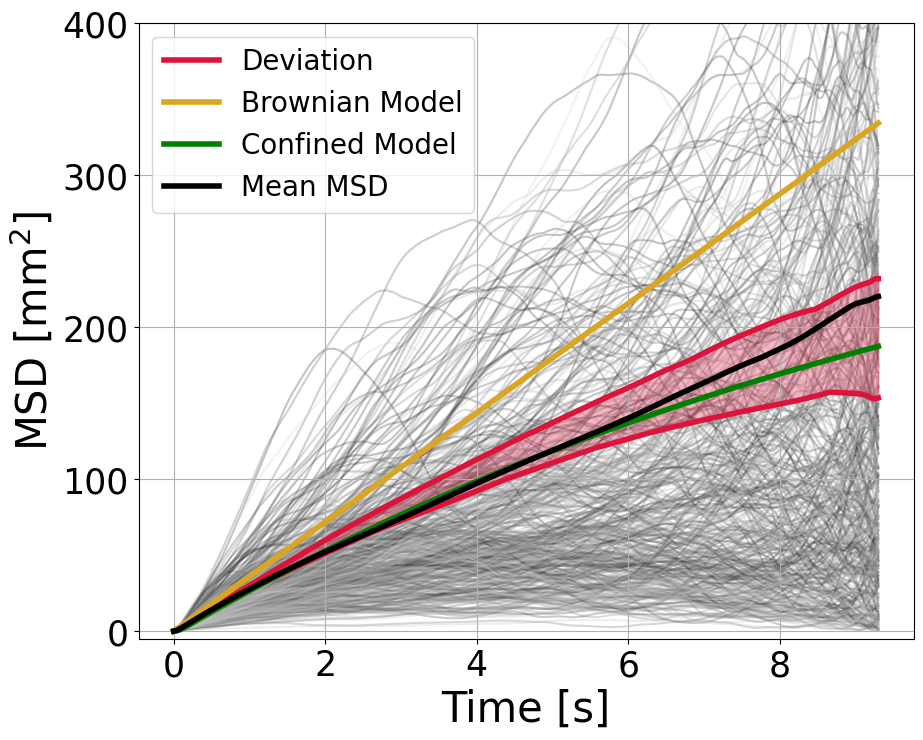

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

# To plot the MSD of each trajectory in the background,
msd_menos500 = [] #We will keep only those trajectories that do not exceed 500 mm^2

for i in range(0,len(msd)):
    if all(x < 500 for x in msd[i]):
      msd_menos500.append(msd[i])

number =  len(msd_menos500)
cmap = plt.get_cmap('gist_gray')
colors = [cmap(i) for i in np.linspace(0, 0.8, number)]

for i, color in enumerate(colors, start=0):
  ax.plot(t, msd_menos500[i], color = color, alpha = 0.25, zorder = 0)


# Theoretical Brownian Motion MSD model
b_x, b_y = 20.9, 17.3
D_x, D_y  = qvx/b_x, qvy/b_y
msdTeorico =  (vx0*t)**2 + (vy0*t)**2 + t*2*D_x+  t*2*D_y


ax.plot(t, max_curve, color = colorStd, linewidth = 4, label = "Deviation")
ax.plot(t, min_curve, color = colorStd, linewidth = 4)
ax.plot(t, msdTeorico, color = 'goldenrod', label = "Brownian Model", linewidth = 4, zorder = 2)
ax.plot(t, msdTeorico_confined, color = "g", linewidth = 4, label = "Confined Model", zorder = 4)
ax.plot(t, msdMean_data, color = colorMean, linewidth = 4, label = "Mean MSD", zorder = 5)

ax.fill_between(t,  min_curve,  max_curve, alpha=0.3, color=colorStd, zorder = 1)
ax.set_xlabel("Time [s]", fontsize = 30)
ax.set_ylabel(r"MSD [mm$^2$]", fontsize = 30)
ax.set_ylim([-5, 400])

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize = 20)
ax.grid(True)

#the figure will be saved in the "Files" folder within the Colab environment
plt.savefig("fig8bMSD.pdf", bbox_inches='tight')

## Simulated MSD

In [13]:
n_simulations = 500
T = 9.333333333333334
dt = 9.333333333333334/280
bx, qvx, wx, by, qvy, wy = 23.0, 170.0, 1.01, 23.0, 170.0, 1.01
vx0, vy0 = 0, 0

Don't run the next two cells if saved data is going to be used

In [30]:
min_curve_50, max_curve_50, msdTeorico_confined = MSD_simulation(n_simulations, 50, T, dt, bx, qvx, wx, by, qvy, wy, vx0, vy0)
min_curve_500, max_curve_500, msdTeorico_confined = MSD_simulation(n_simulations, 500, T, dt, bx, qvx, wx, by, qvy, wy, vx0, vy0)
min_curve_2000, max_curve_2000, msdTeorico_confined = MSD_simulation(n_simulations, 2000, T, dt, bx, qvx, wx, by, qvy, wy, vx0, vy0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


The simulation takes a long time, so it is recommended to save the simulated MSD data

In [31]:
file_path_50 = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/500simulations_50trajectories.txt'  #Replace with the path where you want to save the data
file_path_500 = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/500simulations_500trajectories.txt'  #Replace with the path where you want to save the data
file_path_2000 = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/500simulations_2000trajectories.txt'  #Replace with the path where you want to save the data

data_50 = {'min MSD': min_curve_50, 'max MSD': max_curve_50}
data_500 = {'min MSD': min_curve_500, 'max MSD': max_curve_500}
data_2000 = {'min MSD': min_curve_2000, 'max MSD': max_curve_2000}

with open(file_path_50, 'w') as file:
    json.dump(data_50, file)

with open(file_path_500, 'w') as file:
    json.dump(data_500, file)

with open(file_path_2000, 'w') as file:
    json.dump(data_2000, file)

To load the saved simulation

In [8]:
file_path_50 = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/500simulations_50trajectories.txt'  #Replace with the path where you want to save the data
file_path_500 = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/500simulations_500trajectories.txt'  #Replace with the path where you want to save the data
file_path_2000 = '/content/drive/MyDrive/Caminata paper/Simulation/MSD/500simulations_2000trajectories.txt'  #Replace with the path where you want to save the data

with open(file_path_50, 'r') as file:
    data_50 = json.load(file)

min_curve_50 = data_50['min MSD']
max_curve_50 = data_50['max MSD']

with open(file_path_500, 'r') as file:
    data_500 = json.load(file)

min_curve_500 = data_500['min MSD']
max_curve_500 = data_500['max MSD']

with open(file_path_2000, 'r') as file:
    data_2000 = json.load(file)

min_curve_2000 = data_2000['min MSD']
max_curve_2000 = data_2000['max MSD']

Let's make a plot

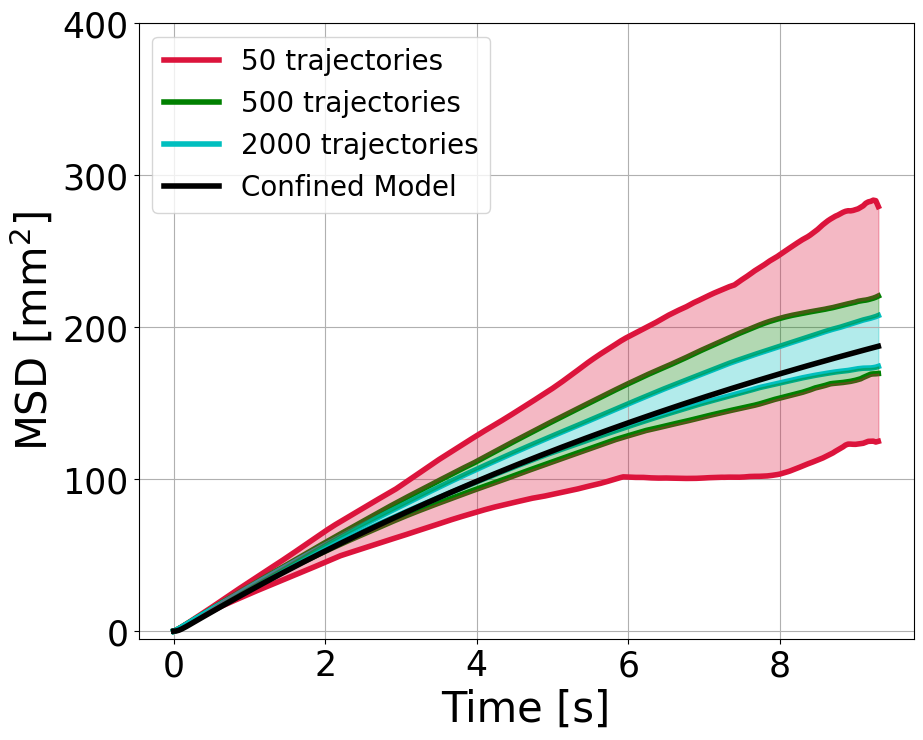

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

#We create a time vector
t = np.arange(0, T, dt)

msdTeorico_confined = MSDConfined(t, bx, qvx, wx) + MSDConfined(t, by, qvy, wy) #the theoretical value

ax.plot(t, max_curve_50, color = colorStd, linewidth = 4, label = "50 trajectories")
ax.plot(t, min_curve_50, color = colorStd, linewidth = 4)
ax.fill_between(t,  min_curve_50, min_curve_500, alpha=0.3, color=colorStd, zorder = 10)
ax.fill_between(t,  max_curve_500,  max_curve_50, alpha=0.3, color=colorStd, zorder = 5)

ax.plot(t, max_curve_500, color = 'g', linewidth = 4, label = "500 trajectories")
ax.plot(t, min_curve_500, color = 'g', linewidth = 4)
ax.fill_between(t,  min_curve_500,  min_curve_2000, alpha=0.3, color='g', zorder = 5)
ax.fill_between(t,  max_curve_2000,  max_curve_500, alpha=0.3, color='g', zorder = 5)


ax.plot(t, max_curve_2000, color = 'c', linewidth = 4, label = "2000 trajectories")
ax.plot(t, min_curve_2000, color = 'c', linewidth = 4)
ax.fill_between(t,  min_curve_2000,  max_curve_2000, alpha=0.3, color='c', zorder = 0)

ax.plot(t, msdTeorico_confined, color = "black", linewidth = 4, label = "Confined Model", zorder = 10)


ax.set_xlabel("Time [s]", fontsize = 30)
ax.set_ylabel(r"MSD [mm$^2$]", fontsize = 30)
ax.set_ylim([-5, 400])

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize = 20)
ax.grid(True)

#the figure will be saved in the "Files" folder within the Colab environment
plt.savefig("apendiceMSD.pdf", bbox_inches='tight')